In [ ]:
import tensorflow as tf
from tensorflow import keras as ks

from tensorflow.keras.datasets import mnist, fashion_mnist

from sklearn.model_selection import train_test_split

import numpy as np
from matplotlib import pyplot as plt

!pip install visualkeras
import visualkeras
from PIL import ImageFont

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 11.7 MB/s eta 0:00:00


## Blind source separation

Notebook realized for [deep learning](https://www.unibo.it/it/studiare/dottorati-master-specializzazioni-e-altra-formazione/insegnamenti/insegnamento/2024/493201)'s university course [@unibo](https://www.unibo.it/it) a.y 2024/2025 February session by [Michele Dinelli](michele.dinelli5@studio.unibo.it) `0001132338`.

This project aims to separate an image, formed as the sum of two images, into its original components.

The two source images, img1 and img2, are drawn from different datasets: MNIST and Fashion-MNIST, respectively.

No preprocessing is allowed. The neural network receives the combined image (img1 + img2) as input and outputs the predicted components (hat_img1,hat_img2).

Performance is evaluated using the mean squared error (MSE) between the predicted and ground-truth images.

Both datasets (MNIST and Fashion-MNIST) are grayscale. For simplicity, all samples are padded to a (32,32) resolution.

Here we load the two datasets, mnist and fashion mnist (both in grayscale).

For simplicity, the samples are padded to dimension (32,32).

In [ ]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.

print(f"mnist x train: {np.shape(mnist_x_train)}")

(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()

fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
mnist x train: (60000, 32, 32)
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Here is a simple datagenerator.

In [ ]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = (x1[num1], x2[num2])

        yield x_data, y_data

Let us define a generator with batchsize=1 and let's test it.

In [ ]:
onegen = datagenerator(mnist_x_test,fashion_mnist_x_test,1)

Let us look at some input-output pairs

In [ ]:
def show_images(x,y1,y2):
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    ax[0].imshow(x,cmap='gray')
    ax[0].title.set_text('Input')
    ax[0].axis('off')
    ax[1].imshow(y1,cmap='gray')
    ax[1].title.set_text('mnist')
    ax[1].axis('off')
    ax[2].imshow(y2,cmap='gray')
    ax[2].title.set_text('fashion_mnist')
    ax[2].axis('off')
    plt.show()

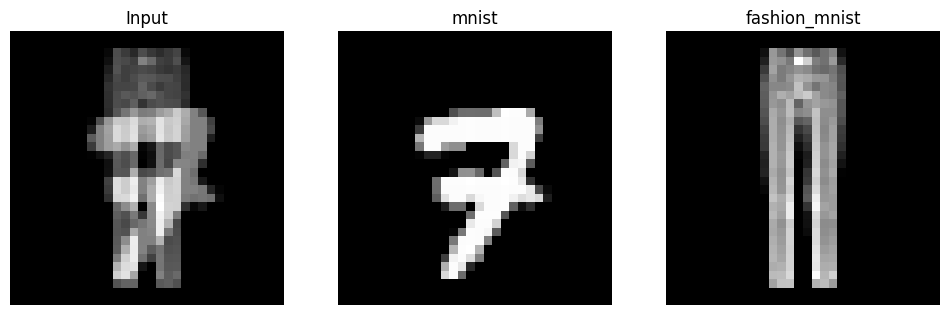

In [ ]:
x, (y1, y2) = next(onegen)
show_images(x[0], y1[0], y2[0])

## Problem analysis

After some research, Blind Source Separation (BSS) appears to be a common problem for audio signal processing [[1]](https://ieeexplore.ieee.org/document/6709849). Audio separation technique has found its place in numerous practical applications and of course also in BSS image separation [[1]](https://ieeexplore.ieee.org/document/6709849) [[2]](https://www.academia.edu/9950457/BLIND_SEPARATION_OF_REFLECTIONS_USING_THE_IMAGE_MIXTURES_RATIO) [[3]](https://link.springer.com/chapter/10.1007/11679363_31).

While looking for a suitable model architecture for the provided task I read about U-Net [[4]](https://arxiv.org/abs/1505.04597) architecture and how it was adapted to audio source separation tasks [[5]](https://arxiv.org/abs/1505.04597). U-Net was originally proposed, as we saw, for Biomedical Image Segmentation but gained popularity for its incredible performances in image generation as it was also used as backbone for Stable Diffusion models [[9]](https://arxiv.org/abs/2309.11497).

U-Net consists of a encoder followed by a decoder connected by connection paths and a bottleneck. The encoder is responsible of exctracting features from the input image while the decoder is responsible of upsampling intermediate features and producing the final output. Encoder and decoder are symmetrical and connected, recalling the U shape, hence the name U-Net.

[U-Net architecture image](https://miro.medium.com/v2/resize:fit:720/format:webp/1*zYrwp34DslR_9wLHMVAITg.png)

### How U-Net works

Features are passed through the encoder which consists of repeated convolutional layers and max pooling layers to extract intermediate features. The extracted features are then upsampled by the corresponding decoder. Saved copies of the corresponding encoder's features are concatendated onto the decoder features using skip connections. In order to train the network, once the final layer produces the output, it is required to calculate the loss with respect of a ground truth image and then backpropagate the gradients through the network to improve predictions [[4]]((https://ieeexplore.ieee.org/document/6709849)). In this BSS problem context the ground truth images are 32x32 mixed images from MNIST and Fashion-MNIST.

- The Encoder: series of 3x3 convolutional layers at each of the stages. At the end of each stage ReLu activation function is applied to each feature. Between the stages a 2x2 max pooling opearation is applied to down-sample the features (the equivalent of picking the largest value in a non-overlapping window rolled across the image). This reduces the spatial dimensions of the features in fact channels are doubled after each max pooling operation.
- Decoder: series of 3x3 convolutional layers at each of the stages again followed by the ReLu activation function. After each stage Decoder upsamples the current set of features applying a 2x2 convolutional layer and halves the number of channels.
- Connecting paths (skip connections): they connect simmetrical parts of Encoder/Decoder and concatenate features from the Encoder on the opposing stage in the Decoder. This means subsequent convolutional layers can operate on both Encoder/Decoder features. Encoder's features should contain spatial information while Decoder's features should contain more semantic information. Comining information is key.
- Bottleneck: where the Encoder switches to Decoder. Features comming from the Encoder are down-sampled with 2x2 max pooling then again 3x3 convolutional layers + ReLu are applied, finally upsamled again.

## Model proposed
The model proposed is a Convolutional Neural Network (CNN) that is inspired by U-Net architecture with some tweaks for the BSS problem. The model consists of 3 encoder/decoder blocks with 3 convolution layers for each block and skip connections between symmetrical encoder/decoder stages. I decided to keep it simple since the images are grayscale 32x32 and I wanted to test more configurations without commiting to a deeper network with tons of parameters which results in slower training (also considering that I am limited by the free-tier GPU usage on Google Colab and the runtime may die at anytime). I slightly modified model's output with respect of the original U-Net model because the problem stated that the model must return two predictions. I added two final convolution layers and then finally return two outputs: the two source images from MNIST and MNIST-Fashion.

### On the number of filters
It's not always the higher the better of course [[8]](https://ieeexplore.ieee.org/document/9142089). There are no rules on how to decide number of filters but the original U-Net double them after each encoder stage so I just had to choose the starting number because I used the same approach.

### On the final layer activation function
I tried to toogle the final layer activation function between ReLU and sigmoid and results were basically the same but ReLU was slightly better. I decided to keep it since outputs should be in a range that preserves fine details without forcing values into [0,1].

### On activation functions
I also came across Leaky ReLU activation function and I considered to use it through the layers since some neurons may always output 0 permanently (dying ReLU [[6]](https://arxiv.org/abs/1903.06733) problem), if weights are updated poorly. Leaky ReLU prevents this by keeping a small negative slope but since the model isn't very deep I didn't pursued the idea. Allowing small negative values, may preserve too much noise rather than focusing on meaningful features.

### On the dropout
Dropout is a regularization technique to prevent overfitting. It (pseudo)randomly disables a fraction of neurons during training so the network is forced to learn more robust features instead of relying on specific neurons. It can prevent overfitting and it is like training smaller networks and then averaging them. Of course there is some overhead introduced and slower convergence since not all the neurons are active. I thought about introducing dropout considering that I also had to make these adjustments: increase the network size and increase learning rate. Increasing the learning rate and ,maybe even adding momentum may result in large weight values so it should also a valid choice adding max-norm regularization [[7]](https://link.springer.com/article/10.1007/s11042-019-08453-9). I finally opted to avoid dropout.

### On the batch normalization
During training of a neural network, the distribution of the input values of each layer is affected by all layers that come before it. This variability reduces training speed (lower learning rates). Batch normalization was created to resolve this variability and speed up learning [[7]](https://link.springer.com/article/10.1007/s11042-019-08453-9). The way batch normalization operates, by adjusting the value of the units for each batch, and the fact that batches are created randomly during training, results in more noise during the training process. The noise acts as a regularizer. This regularization effect is similar
to the one introduced by dropout. As a result, dropout can be removed completely from the network or should have its rate reduced significantly if used in conjunction with batch normalization. I chose to add batch normalization since it was proven to be effective in CNN training stabilization carrying the best result in similar tasks [[7]]((https://link.springer.com/article/10.1007/s11042-019-08453-9)).

#### References

1. [Blind source separation: A review and analysis](https://ieeexplore.ieee.org/document/6709849)
2. [Blind Separation Of Reflections Using The Image Mixtures Ratio](https://www.academia.edu/9950457/BLIND_SEPARATION_OF_REFLECTIONS_USING_THE_IMAGE_MIXTURES_RATIO)
3. [Efficient Separation of Convolutive Image Mixtures](https://link.springer.com/chapter/10.1007/11679363_31)
4. [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)
5. [Blind source separation based on improved Wave-U-Net network](https://www.researchgate.net/publication/375427672_Blind_source_separation_based_on_improved_Wave-U-Net_network)
6. [Dying ReLU and Initialization: Theory and Numerical Examples](https://arxiv.org/abs/1903.06733)
7. [Dropout vs. batch normalization: an empirical study of their impact to deep learning](https://link.springer.com/article/10.1007/s11042-019-08453-9)
8. [The Impact of Filter Size and Number of Filters on Classification Accuracy in CNN](https://ieeexplore.ieee.org/document/9142089)
9. [FreeU: Free Lunch in Diffusion U-Net](https://arxiv.org/abs/2309.11497)

In [ ]:
def encoder_block(inputs, layer_idx, total_blocks, num_channels, conv_layers_per_block, skip_connections):
    x = inputs
    for _ in range(conv_layers_per_block):
        x = ks.layers.Conv2D(num_channels, kernel_size=3, padding='same')(x)
        x = ks.layers.BatchNormalization()(x)
        x = ks.layers.ReLU()(x)

    if layer_idx < total_blocks - 1:
        skip_connections.append(x)  # Store the features for skip connections
        x = ks.layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
        num_channels *= 2  # Double channels

    return x, num_channels

def decoder_block(inputs, layer_idx, total_blocks, num_channels, conv_layers_per_block, skip_connections):
    num_channels //= 2 # Halves channels

    h = ks.layers.Conv2DTranspose(num_channels, 3, strides=2, padding='same')(inputs)
    skip_features = skip_connections.pop(-1)
    x = ks.layers.Concatenate()([h, skip_features])

    for _ in range(conv_layers_per_block):
        x = ks.layers.Conv2D(num_channels, kernel_size=3, padding='same')(x)
        x = ks.layers.BatchNormalization()(x)
        x = ks.layers.ReLU()(x)

    return x, num_channels

def build_model(input_shape, initial_channels=32, num_blocks=4, conv_layers_per_block=2):
    inputs = ks.layers.Input(shape=input_shape)
    skip_connections = []

    x = inputs
    num_channels = initial_channels
    for block_idx in range(num_blocks):
        x, num_channels = encoder_block(x, block_idx, num_blocks, num_channels, conv_layers_per_block, skip_connections)

    for block_idx in range(num_blocks - 1):
        x, num_channels = decoder_block(x, block_idx, num_blocks, num_channels, conv_layers_per_block, skip_connections)

    output_mnist = ks.layers.Conv2D(1, kernel_size=1, activation='relu', name='mnist_out')(x)
    output_fashion_mnist = ks.layers.Conv2D(1, kernel_size=1, activation='relu', name='fashion_mnist_out')(x)

    return ks.models.Model(inputs, [output_mnist, output_fashion_mnist])

model = build_model(input_shape=(32, 32, 1), initial_channels=64, num_blocks=3, conv_layers_per_block=3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 64)     │              0 │ re_lu_2[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 16, 16, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 16, 16, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_4 (ReLU)       

 Total params: 3,033,346 (11.57 MB)

 Trainable params: 3,029,506 (11.56 MB)

 Non-trainable params: 3,840 (15.00 KB)

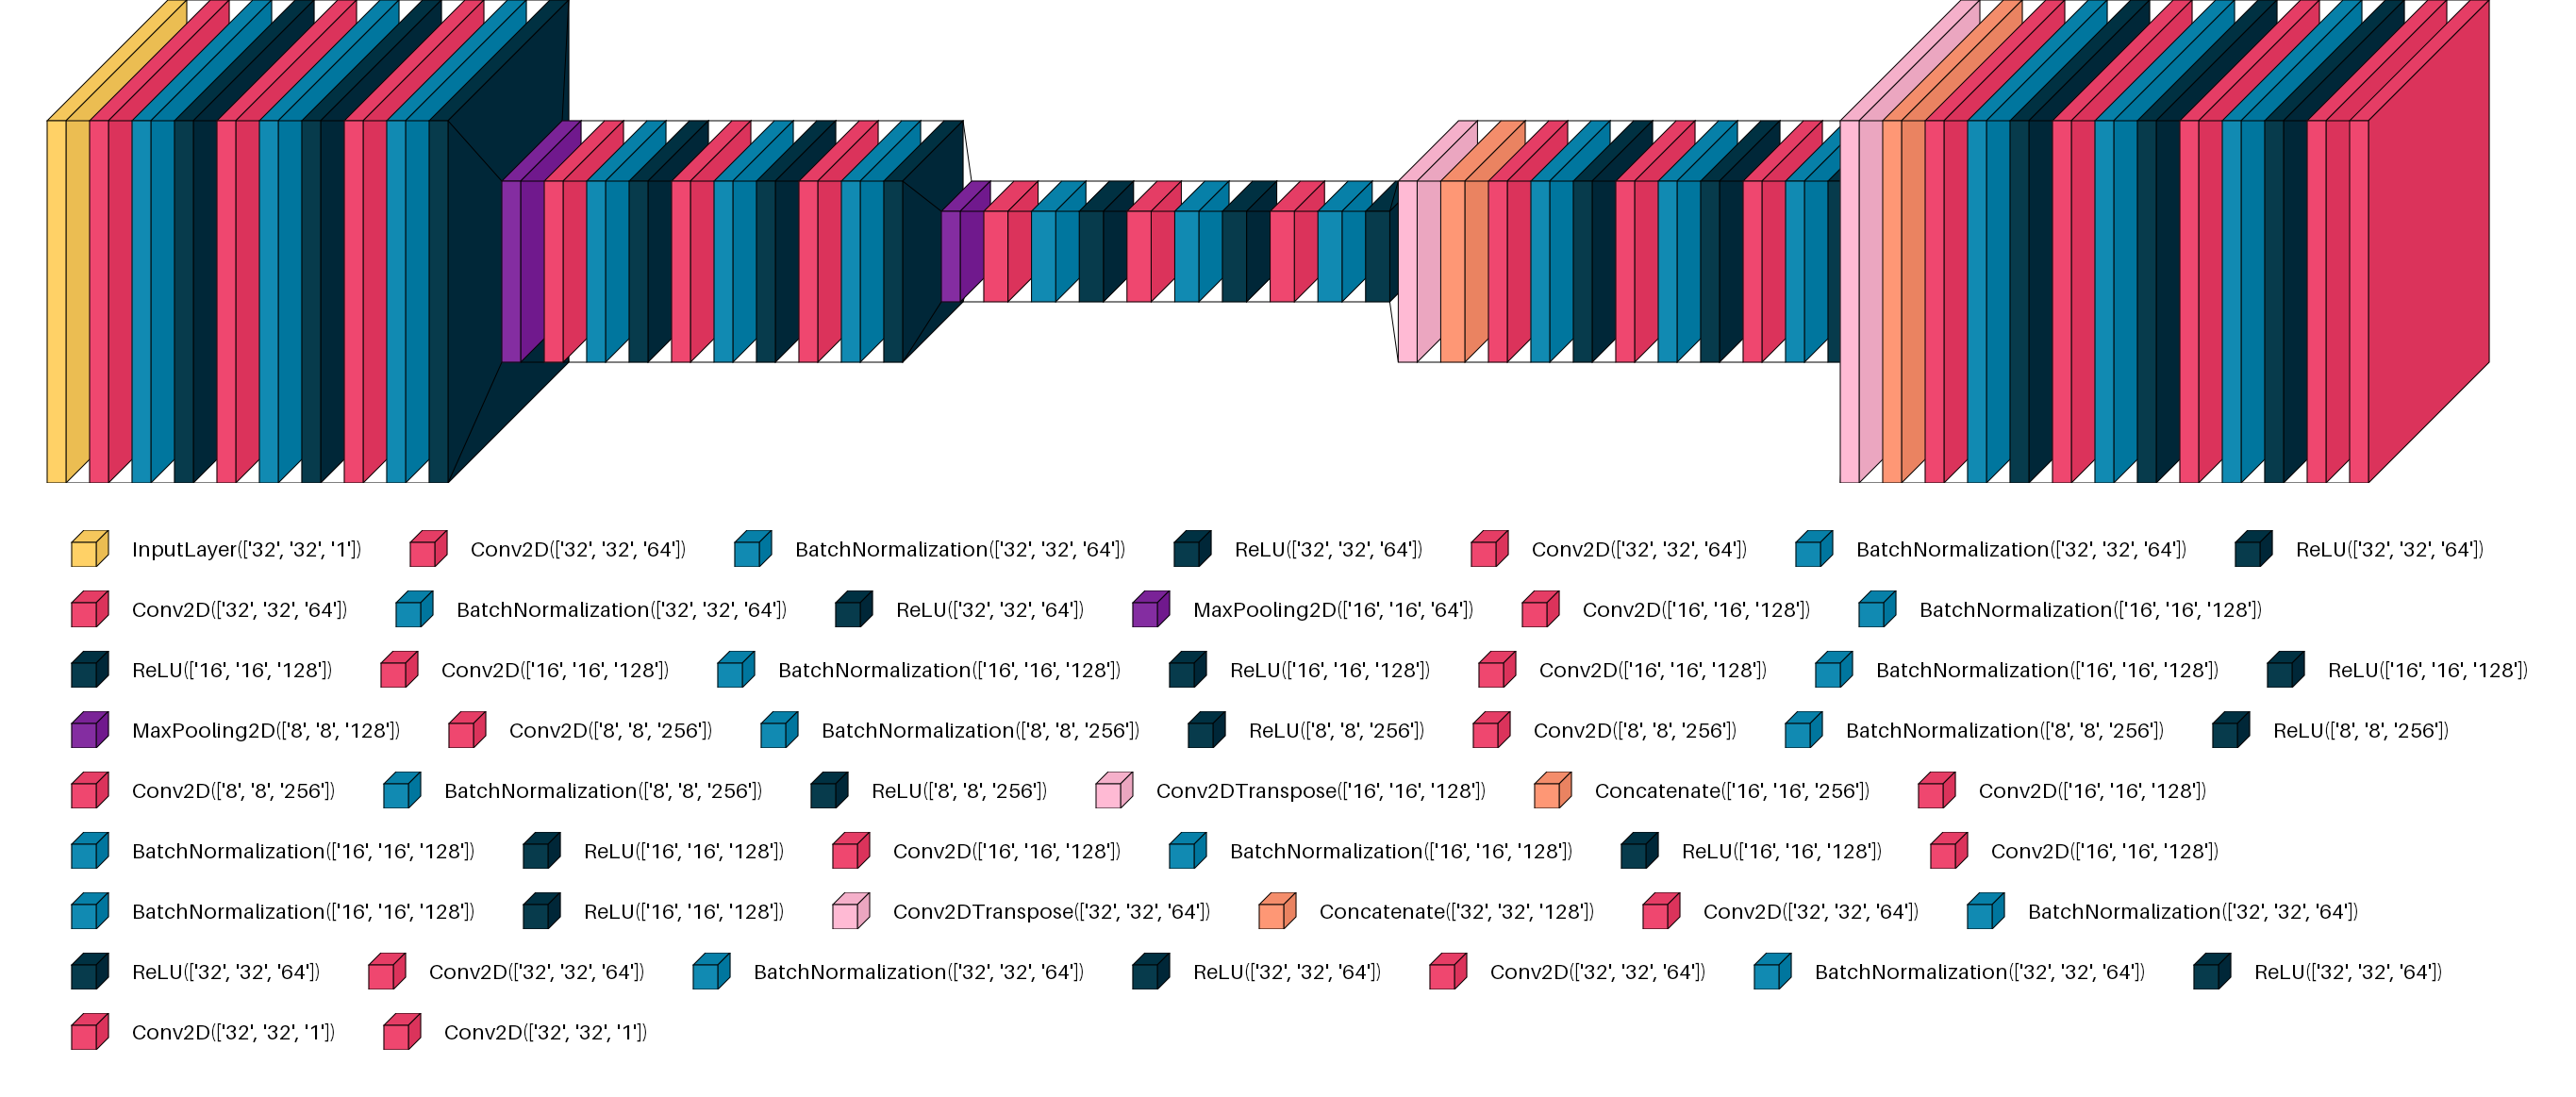

In [ ]:
font = ImageFont.load_default(size=22)
visualkeras.layered_view(model, legend=True, font=font, show_dimension=True, scale_xy=12, spacing=25, padding=50)

## Training

The model has been trained multiple times with hyperparameter tuning between each round of training. The notebook will report only the last training round. Some training data are sacrificed for validation purposes.

I chose Adam as optimizer which is pretty standard and 32 as batch size. The number of steps per epoch is a function of the number of training samples and the batch size. I tried also adding a constant factor to increase the number of steps per epoch but the default configuration (`train_samples // batch_size`) appears to behave well. I decided to train the model for 150 epochs which probably can be a little too much so I added a callback for early stopping with `patience = 10`. I also added a model checkpoint callback to store what are considered the best weights. Finally I added a callback to reduce learning rate on plateau with `patience = 8` and `min_lr = 1e-5` while the initial learning rate is set to `1e-3`. I did not specify how to weight each individual output so the shared loss function will be handled by Keras, the default behaviour is computing the loss as the sum of the losses. I considered that the default behaviour i.e. summing losses keeps the absolute magnitude of losses but if one has a much larger loss, it can dominate training. Losses seem to float in the same ranges so I decided to leave it as default.

In [ ]:
mnist_train, mnist_val = train_test_split(mnist_x_train, test_size=0.1)
fashion_mnist_train, fashion_mnist_val = train_test_split(fashion_mnist_x_train, test_size=0.1)

train_samples = mnist_train.shape[0]
val_samples = mnist_val.shape[0]

print(f'MNIST\nTrain set: {mnist_train.shape}\nValidation set: {mnist_val.shape}\n')
print(f'Fashion MNIST\nTrain set: {fashion_mnist_train.shape}\nValidation set: {fashion_mnist_val.shape}')

MNIST
Train set: (54000, 32, 32)
Validation set: (6000, 32, 32)

Fashion MNIST
Train set: (54000, 32, 32)
Validation set: (6000, 32, 32)


In [ ]:
batch_size = 32
learning_rate = 1e-3
epochs = 150

steps_per_epoch = train_samples // batch_size
validation_steps = val_samples // batch_size

In [ ]:
train_generator = datagenerator(mnist_train, fashion_mnist_train, batch_size)
val_generator = datagenerator(mnist_val, fashion_mnist_val, batch_size)

In [ ]:
callbacks = [
    ks.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=8, min_lr=1e-5, mode='min', verbose=1),
    ks.callbacks.ModelCheckpoint(filepath="best.weights.h5", save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True, verbose=1),
    ks.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

optimizer = ks.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse', metrics=['mse', 'mse'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/150
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - fashion_mnist_out_loss: 0.0178 - fashion_mnist_out_mse: 0.0178 - loss: 0.0263 - mnist_out_loss: 0.0085 - mnist_out_mse: 0.0085
Epoch 1: val_loss improved from inf to 0.00454, saving model to best.weights.h5
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 79s 34ms/step - fashion_mnist_out_loss: 0.0178 - fashion_mnist_out_mse: 0.0178 - loss: 0.0263 - mnist_out_loss: 0.0085 - mnist_out_mse: 0.0085 - val_fashion_mnist_out_loss: 0.0027 - val_fashion_mnist_out_mse: 0.0027 - val_loss: 0.0045 - val_mnist_out_loss: 0.0019 - val_mnist_out_mse: 0.0019 - learning_rate: 0.0010
Epoch 2/150
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - fashion_mnist_out_loss: 0.0022 - fashion_mnist_out_mse: 0.0022 - loss: 0.0039 - mnist_out_loss: 0.0016 - mnist_out_mse: 0.0016
Epoch 2: val_loss improved from 0.00454 to 0.00377, saving model to best.weights.h5
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 59s 35ms/step - fashion_mnist_out_loss: 0.0022 - fashion_mnist_out_mse: 0.0022 - loss: 0

After 69 epochs the training stopped because of the early stop callback (10 consecutive epochs without improvement). The best epoch was the 59th and weights are saved. The learning rate reached a quite low value (`1e-5`) so I don't think that this kind of model could learn more than this. This is quite good because it isn't a huge model parameter-wise but it reached pretty low validation loss during training (`7.5e-4`) which is the sum of the two output losses.

In [ ]:
def display_history(history):
    loss_training = history.history['loss']
    loss_val = history.history['val_loss']

    mse_mnist_training = history.history['mnist_out_mse']
    mse_mnist_val = history.history['val_mnist_out_mse']

    mse_fashion_training = history.history['fashion_mnist_out_mse']
    mse_fashion_val = history.history['val_fashion_mnist_out_mse']

    plt.plot(loss_training)
    plt.plot(loss_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

    plt.plot(mse_fashion_training)
    plt.plot(mse_fashion_val)
    plt.plot(mse_mnist_training)
    plt.plot(mse_mnist_val)
    plt.grid()
    plt.title('MSE during training')
    plt.xlabel('Epoch')
    plt.legend(['mse_fashion_train', 'mse_fashion_val', 'mse_mnist_train', 'mse_mnist_val'])
    plt.show()

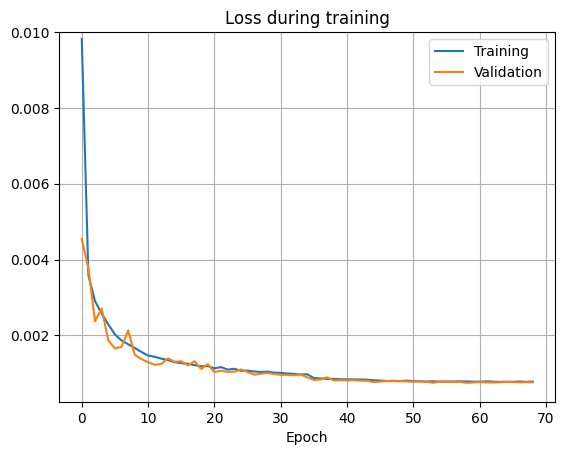

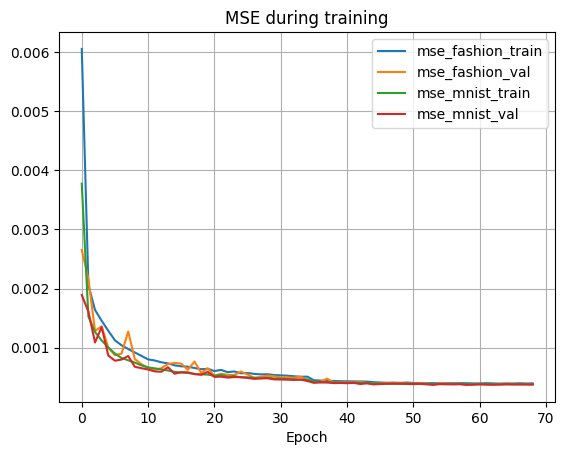

In [ ]:
display_history(history)

The two plots above describe the training history. First of all there are no signs of overfitting.

After epoch 45 the validation loss was stable. In a 20 epoch time it just improved by `2e-5` going from `0.00077` to `0.00075`. I think that to go beyond that point it is required to go way **deeper** with the model. Training time could increase dramatically and I don't trust Google Colab free tier GPU runtimes that much. Of course a possible way to handle that would be saving and re-loading weights but that would leave the notebook a little bit inconsistent.

Since the model outputs two predictions I decided to trace both the output losses and plot their respective values during training. This can be insightful because it tells wether was necessary or not to compute the average of the two loss functions and use it instead of the sum during training. Again, since the two losses are on the same scale I think it was fine to leave the default behaviour handled by Keras.

The first plot describes the loss during training (the sum of mnist and fashion-mnist mean squared errors). Epochs on the x-axis and loss on the y-axis. Training loss in orange and validation loss in blue.

The second plot is basically the first plot unpacked, since mnist and mnist-fashion mean squared errors progression are plotted separately.

## Model evaluation

In order to test the model I followed the provided guidelines.

I had to reshape model's output removing the image channel to match ground truth images since they don't have the channel dimension. Mean Squared Error (MSE) is calculated for both outputs and then averaged to get the final evaluation metric.

The evaluation process is repeated 10 times to get a more reliable estimation (5000 * 10 samples in total).

The average **mse** obtained is **0.000388121648599426**

The **standard deviation** is **7.954220393637751e-06**. That means there is no significative variance between mse results.

In [ ]:
testgen = datagenerator(mnist_x_test, fashion_mnist_x_test, 5000)

In [ ]:
def eval_model(model):
    x, (y1,y2) = next(testgen)

    pred1,pred2 = model.predict(x)

    # Remove channel to match ground truth labels
    # Reshape: (5000, 32, 32, 1) -> (5000, 32, 32)
    pred1 = np.squeeze(pred1, axis=-1)
    pred2 = np.squeeze(pred2, axis=-1)

    return (np.mean((pred1-y1)**2) + np.mean((pred2-y2)**2)) / 2

In [ ]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(model))
print("mse = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
mse =  0.000388121648599426
standard deviation =  7.954220393637751e-06


### Some predictions examples

In [ ]:
def plot_n_predictions(n=4, batch_size=8):
    generator = datagenerator(mnist_x_test,fashion_mnist_x_test, batch_size)
    x, (y1, y2) = next(generator)
    pred1, pred2 = model.predict(x)

    n = min(n, batch_size)

    fig, ax = plt.subplots(n, 3, figsize=(12, 4 * n))

    for i in range(n):
        input_image = x[i]
        pred1_image = pred1[i]
        pred2_image = pred2[i]

        input_image = np.squeeze(input_image, axis=-1) if input_image.shape[-1] == 1 else input_image
        pred1_image = np.squeeze(pred1_image, axis=-1) if pred1_image.shape[-1] == 1 else pred1_image
        pred2_image = np.squeeze(pred2_image, axis=-1) if pred2_image.shape[-1] == 1 else pred2_image

        # Plot Input Image
        ax[i, 0].imshow(input_image, cmap="gray")
        ax[i, 0].set_title("Input (MNIST + Fashion)")
        ax[i, 0].axis("off")

        # Plot MNIST Output
        ax[i, 1].imshow(pred1_image, cmap="gray")
        ax[i, 1].set_title("Predicted MNIST")
        ax[i, 1].axis("off")

        # Plot Fashion-MNIST Output
        ax[i, 2].imshow(pred2_image, cmap="gray")
        ax[i, 2].set_title("Predicted Fashion-MNIST")
        ax[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


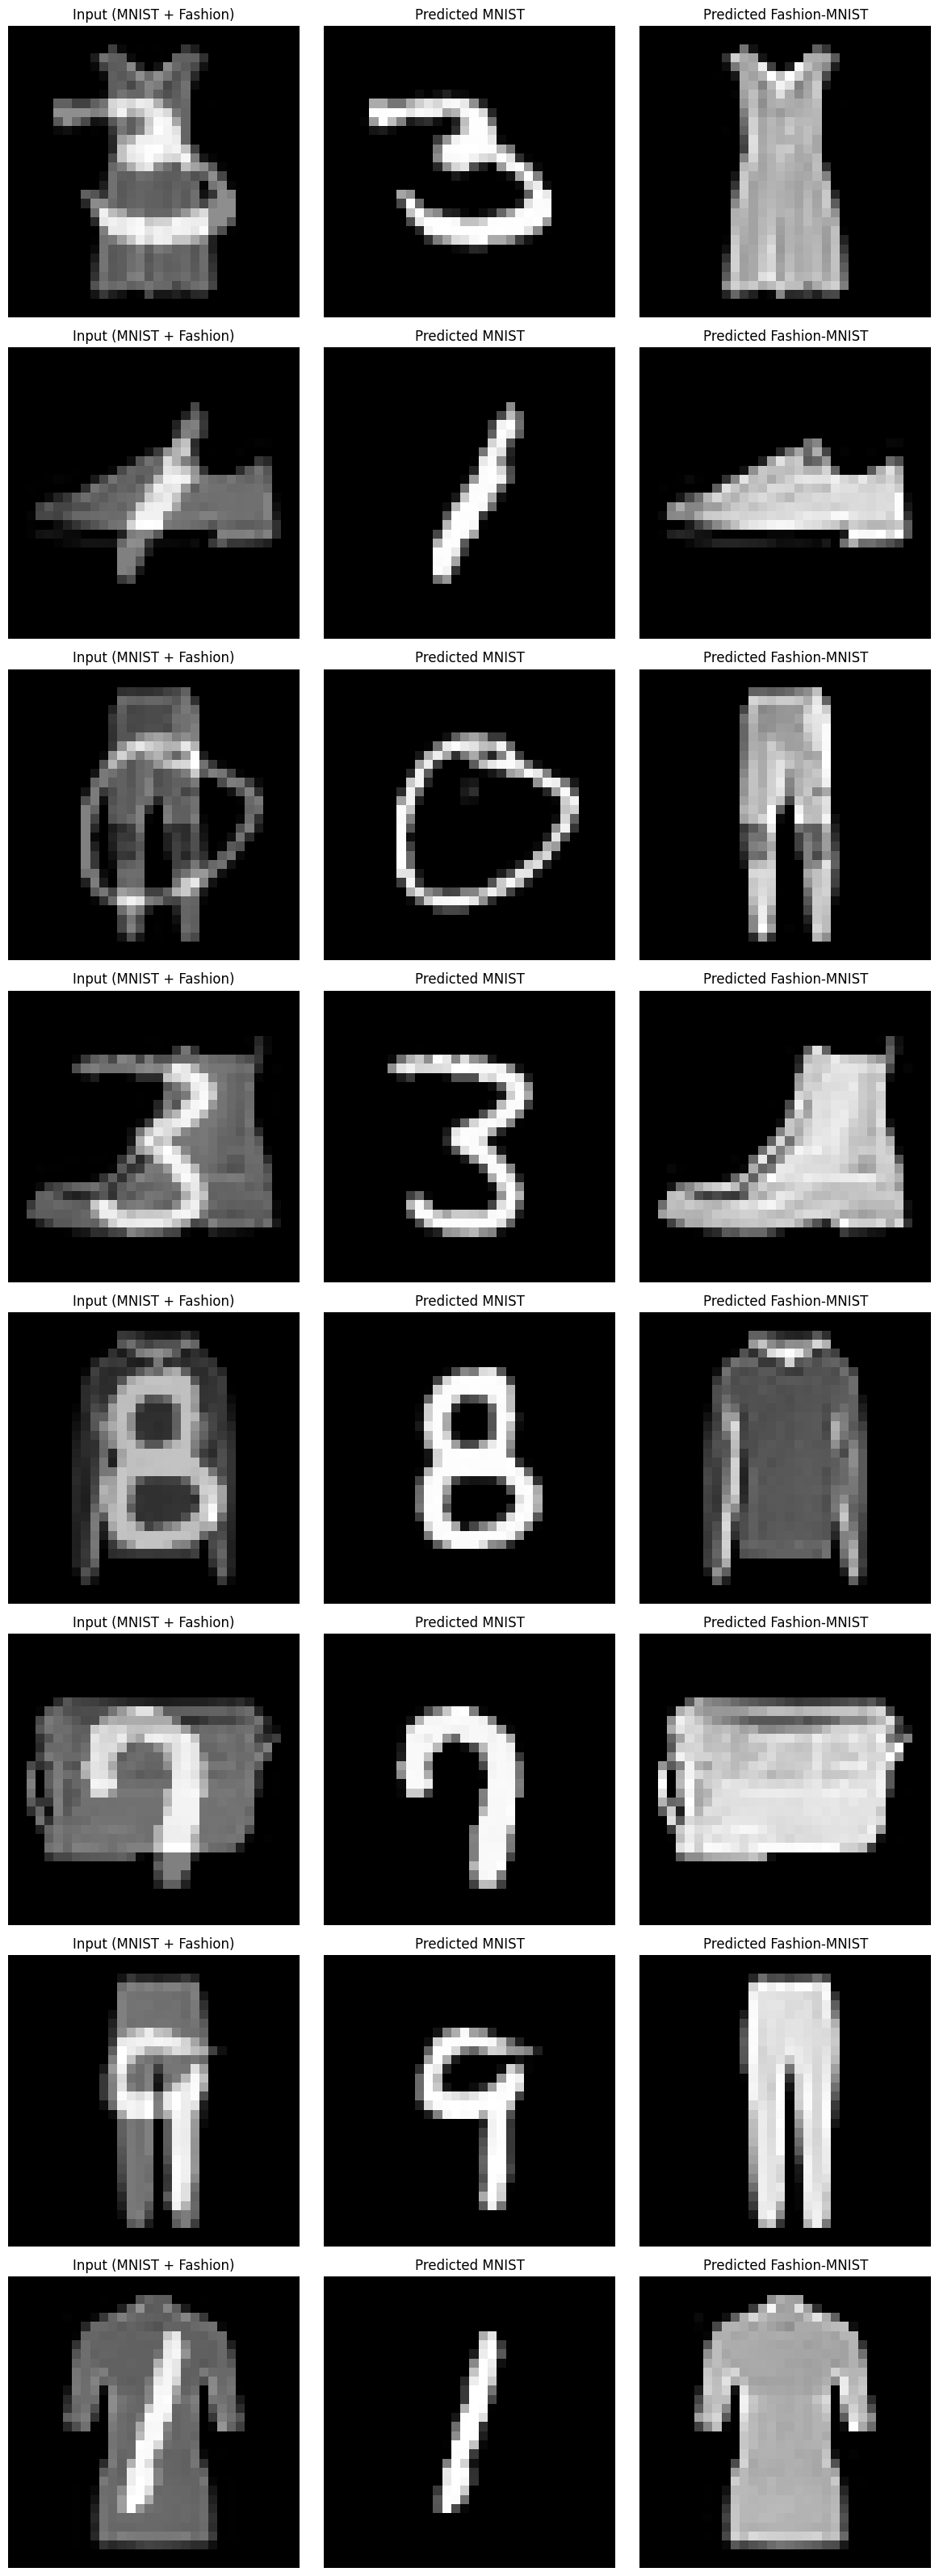

In [ ]:
plot_n_predictions(n=8)

## Conclusion
The model proposed is inspired by the U-Net architecture with 3 blocks for encoder/decoder, skip connections and 3 convolutions per block. I decided to add batch normalization between each convolution step both in encoder and decoder stages. The number of starting filters is 64, they are doubled at each block during the encoder phase and they are halved during decoder phase. Skip connections ensure symmetrical block-wise feature sharing, resulting in pixel-perfect precision for both semantical (decoder) and positional (encoder) feature extraction.

### Results
- The mean squared error (**mse**) against 50000 samples is **0.000388121648599426**.
- Standard deviation of **7.954220393637751e-06** during tests.

### Possible improvements
I would try to increase the starting amount of filters to 128 but this would certainly mean a parameters count explosion and increased training time. I'd also try to reduce the number of convolutions each block while keeping 128 as starting filters. This should balance training time, resulting in an even more precise network that isn't overly sophisticated. I believe there is no need for dropout because the model is not overfitting and apparently it can already generalize well. Data augmentation is also unnecessary due to the large volume of data.